# Experiment 3


<br><br>

### Exp3

As Exp 1-2 demonstrated superposition in the Linear model with ReLU filter using the MNIST handwritten digit image dataset when high sparsity level is set (e.g. 0.999), the next step is to test if a SAE model represents monosemantic-like features (each or a few neurons representing a particular feature) of the handwritten digit datasets when the dataset is set with large sparsity level (e.g. 0.999).

1. The first exp will test to replicate one of the [Anthropic research outcome (Bricken et al., 2023)](https://transformer-circuits.pub/2023/monosemantic-features/index.html) (see the activation historgram in the diagram below), demonstrating that a or a few specific neurons is only activated to a specific input (the below example demonstrating sensitive responds of neuron-489 to "a mixture of different non-English languages" inputs). Thus, this exp will assess if only a small portion of neurons will be activated to each digit image. 
2. Once the first exp is successful, the second exp will test if purely activating specific features alone will reconstruct these specific inputs (e.g. only activating feature- or neuron-1 will reconstruct an image of digit 0).

<br>


![img title](../img/exp3_diagram2.png "Diagram2")

<br>

To make more specifics, I will test two directions in Exp3 (see the below diagram for visual summary),
- The 1st exp (the brown rectangle boxes):
    - a toy model is the same Linear model with one hidden layer (49 dim) and a ReLU filtering function.
    - decomposing features from the original dim (49 dim) into a larger dim (49*2 dim) with varied sparsity level (0.1 vs 0.999) via sparse autoencoder (SAE) model.
    - if small sparsity level is set (0.1), feature representations will be limited with a fewer neurons,
        - which is demonstrated by activation histogram (like the above diagram) with a larger tail at low activation and only a few neurons with large activation for each digit. [(Figure 1)](#Figure-1)
    - if high sparsity level is set (0.999), feature representations will be more spread across neurons,
        - which is demonstrated by activation histogram with a smaller tail at low activation and more neurons with midium to large activation for each digit. [(Figure 2)](#Figure-2)
- The 2nd exp (the orange rectangle box): 
    - training the gen model (49 dim) with features of the original hidden layer (49 dim) and the MNIST digit image datasets and test if activation of the hidden layer feature alone can reconstruct the original images with the gen model. [(Figure 3)](#Figure-3)

<br><br>

![img title](../img/exp3_diagram1.png "Diagram1")


<br><br>

### Exp3.0. Prepare packages

<br><br>


In [1]:
### import packages 

# ml/nn
import torch
import torch.nn as nn  # all neural network modules
import torch.nn.functional as F  # Functions with no parameters -> activation functions
import torch.optim as optim  # optimization algo

from torch.utils.data import DataLoader, Dataset # easier dataset management, helps create mini batches
from torch.utils.data import random_split # set train-test ratio

# import torchvision
import torchvision.datasets as datasets  # standard datasets
import torchvision.transforms as transforms # this for convert dataset to tensor
from torchvision.utils import make_grid # this for visualization

# stats/ml #1
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# stats/ml #2
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances

import random


<br><br>

### Exp3.1. Run first exp

<br><br>


In [2]:
### set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
### define original functions

# Function to add an image at each point
def add_image(ax, img, xy, zoom=0.3):
    imagebox = OffsetImage(img, zoom=zoom, cmap='gray')  # Use `cmap` for grayscale images
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

In [4]:
### Define all parameters

# later these will be inserted at the beginning as args

# fixed
batch_size = 64
input_size = 784
num_classes = 10

# variable
hidden_size = 49 # for lin model
hidden_size2 = 49*4 # for sae hidden dim
lr1 = 0.001
lr2 = 0.0001
lr3 = 0.0001

# when sparsity lv is close to 0, feature is dense
sparsity_lv = 0.1 # vary sparsity level from 0.001-0.999
sparsity_impact = 1e-4 # 1e-4 # 
eps = 1e-7 # epsilon

In [5]:
# Function to scramble MNIST images
def scramble_batch_images(images, block_size=4):
    """Scrambles a batch of images into blocks of block_size x block_size."""
    batch_size, channels, height, width = images.size()
    assert channels == 1 and height == 28 and width == 28, "Only supports MNIST-sized images with 1 channel."
    
    num_blocks = height // block_size  # Number of blocks along one dimension
    scrambled_images = torch.zeros_like(images)  # Prepare output tensor
    
    for b in range(batch_size):
        img = images[b, 0]  # Extract single image, shape [28, 28]
        scrambled_img = torch.zeros_like(img)
        
        # Define block indices
        block_indices = torch.arange(num_blocks**2).view(num_blocks, num_blocks)
        flat_indices = block_indices.flatten().tolist()
        random.shuffle(flat_indices)  # Shuffle the indices
        
        # Rearrange blocks based on shuffled indices
        idx = 0
        for i in range(num_blocks):
            for j in range(num_blocks):
                src_idx = divmod(flat_indices[idx], num_blocks)
                src_i, src_j = src_idx
                scrambled_img[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = \
                    img[src_i*block_size:(src_i+1)*block_size, src_j*block_size:(src_j+1)*block_size]
                idx += 1
        
        scrambled_images[b, 0] = scrambled_img  # Save the scrambled image back
    
    return scrambled_images

In [6]:
# Create a dataset of scrambled images with incorrect labels
class ScrambledMNISTDataset(Dataset):
    def __init__(self, original_dataset, block_size=4):
        self.original_dataset = original_dataset
        self.block_size = block_size
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        original_image, _ = self.original_dataset[idx]  # Ignore original label
        scrambled_image = scramble_batch_images(original_image.unsqueeze(0), self.block_size)  # Add batch dimension
        
        # Assign an incorrect label
        incorrect_label = 10  # A label outside the range 0-9
        
        return scrambled_image.squeeze(0), incorrect_label

In [7]:
### define datasets

# load dataset
train_dataset = datasets.MNIST(root='../dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms.ToTensor(), download=True)

# Create the scrambled dataset
block_size = 4
scrambled_train = ScrambledMNISTDataset(train_dataset, block_size)
scrambled_test = ScrambledMNISTDataset(test_dataset, block_size)

# Combine original and scrambled datasets into a single DataLoader
combined_train = torch.utils.data.ConcatDataset([train_dataset, scrambled_train])
combined_test = torch.utils.data.ConcatDataset([test_dataset, scrambled_test])

train_loader = DataLoader(combined_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combined_test, batch_size=batch_size, shuffle=False)

# when add scrambled
num_classes = 11

# # classic way
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
### implement single layer linear (MLP) model, classic autoencoder model, sparse autoencoder model

# sparse autoencoder (SAE)
class sae_model(nn.Module):
    def __init__(self, encoder, decoder, sparsity_lambda=1e-4, sparsity_target=0.8, epsilon=1e-8):
        super(sae_model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sparsity_lambda = sparsity_lambda # sparsity penalty impact
        self.sparsity_target = sparsity_target # target sparsity distribution
        self.epsilon = epsilon

        # paper said, initialization use the Kaiming Uniform initialization
        nn.init.kaiming_uniform_(self.encoder.fc_enc.weight)
        nn.init.constant_(self.encoder.fc_enc.bias, 0)
        
        # paper said, initialization use the Kaiming Uniform initialization
        nn.init.kaiming_uniform_(self.decoder.fc_dec.weight)
        nn.init.constant_(self.decoder.fc_dec.bias, 0)
        
    def forward(self, x):
        encoded = self.encoder(x, self.decoder.fc_dec.bias)
        decoded = self.decoder(encoded)
        return decoded, encoded

    # paper said used sum, but I will explore with kl divergence
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = self.epsilon
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1 - epsilon)
        kl_divergence = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        sparsity_penalty = torch.sum(kl_divergence)
        return self.sparsity_lambda * sparsity_penalty
    
    def loss_function(self, x_hat, x, encoded):
        mse_loss = F.mse_loss(x_hat, x)
        sparsity_loss = self.sparsity_penalty(encoded)
        return mse_loss + sparsity_loss

# encoder net/layer for sae
class encoderNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(encoderNN, self).__init__()
        self.fc_enc = nn.Linear(input_size, hidden_size)
    def forward(self, x, pre_bias):
        # follow the Anthropic SAE setup
        x = x - pre_bias # pre-encoder bias
        x = self.fc_enc(x) # 49-> 49xn dim
        # x = torch.tanh(x) # range [-1:1] as similar operations as previous exp
        x = F.relu(x)
        return x

# decoder net/layer for sae
class decoderNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(decoderNN, self).__init__()
        self.fc_dec = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc_dec(x) # 49xn dim -> 49(orig)
        # x = torch.tanh(x) # range [-1:1]
        # x = F.relu(x) # range [0:1] as lin model
        return x

# lin model
class lin_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):  
        super(lin_model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input: 28x28=784, hidden: 7x7=49
        self.fc2 = nn.Linear(hidden_size, num_classes) # hidden: 49, num_classes: 10
    def forward(self, x):
        x = self.fc1(x) # 784 -> 49
        x = torch.tanh(x) # range [-1:1]
        x_h = F.relu(x) # add non-linearity [0:1]
        x = self.fc2(x_h) # 49->10
        return x, x_h

# reconstruct original image
class ae4img_gen(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ae4img_gen, self).__init__()
        # self.fc1 = nn.Linear(input_size, hidden_size) # input: 784, target_dim: 49
        # self.fc2 = nn.Linear(hidden_size, input_size) # reconstruct image 784
        self.fc1 = nn.Linear(hidden_size, input_size) # reconstruct image 784
    def forward(self, x):
        # x = self.fc1(x) # 784->49
        # x = torch.tanh(x) # range within [-1:1]
        # x_h = F.relu(x) # add non-linearity
        # x = self.fc2(x_h) # 49->784
        x = self.fc1(x) # 49->784
        x = torch.sigmoid(x) # range within [0:1] as orig image is 0-1
        return x

In [9]:
### initialize model, loss, optimizer

# linear
m1 = lin_model(
    input_size=input_size, # 784
    hidden_size=hidden_size, # 49
    num_classes=num_classes, # 10
).to(device)

# encoder/decoder nets
enc_m = encoderNN(input_size=hidden_size, hidden_size=hidden_size2) # 49 -> 49*n
dec_m = decoderNN(hidden_size=hidden_size2, output_size=hidden_size) # 49*n -> 49

# sae
m2 = sae_model(
    encoder=enc_m, decoder=dec_m, 
    sparsity_lambda=sparsity_impact, 
    sparsity_target=sparsity_lv, 
    epsilon=eps
).to(device)

# imageGen
m3 = ae4img_gen(
    input_size=input_size, # 784
    hidden_size=hidden_size, # 49
).to(device)

# Loss
criterion1 = nn.CrossEntropyLoss() # lin
# criterion2 = nn.MSELoss() # sae
criterion3 = nn.MSELoss() # img gen

# Optimizer
opt1 = optim.Adam(m1.parameters(), lr=lr1)
opt2 = optim.Adam(m2.parameters(), lr=lr2)
opt3 = optim.Adam(m3.parameters(), lr=lr3)

In [10]:
### train and validaiton

# phase 1: train lin/cnn models to predict hand-written digit classes
def phase1(model1, criterion1, opt1, epo_n):
    # training
    for epoch in range(epo_n):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # reshape [batch, 1, 28,28] to [batch, 28*28]
            data = data.view(data.size(0), -1)
    
            # Step 1: Forward pass through model1
            out1, h1 = model1(data) # out1:[batch, 10] as 10 class, h1:[batch, 49] as 49 latent
            # Step 2: Compute loss1 and update model1
            loss1 = criterion1(out1, targets)
            
            opt1.zero_grad()
            loss1.backward()
            opt1.step()
    
        num_correct = 0
        num_samples = 0
        
        # validation
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(test_loader):
                data = data.view(data.size(0), -1)
                out1, _ = model1(data)
                _, predictions = out1.max(1)
                num_correct += (predictions == targets).sum()
                num_samples += predictions.size(0)
    
            accuracy = num_correct/num_samples
        
        print(f"Epoch [{epoch+1}/{epo_n}], loss: {loss1.item():.4f}, accuracy: {accuracy.item():.4f}")

# phase 2: train sae models to reconstruct trained hidden layer
def phase2(model1, model2, opt2, epo_n):
    # training
    for epoch in range(epo_n):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # reshape [batch, 1, 28,28] to [batch, 28*28]
            data = data.view(data.size(0), -1)
    
            with torch.no_grad():
                _, h1 = model1(data) # out1:[batch, 10] as 10 class, h1:[batch, 49] as 49 latent
                h1_clone = h1.detach()
            
            h1_hat, h2 = model2(h1_clone)  # 49 -> 49*2 -> 49
            loss2 = model2.loss_function(h1_hat, h1_clone, h2)
            opt2.zero_grad()
            loss2.backward()
            opt2.step()
        
        # validation
        with torch.no_grad():
            losses = 0
            count = 0
            for batch_idx, (data, targets) in enumerate(test_loader):
                batch_weight = len(data)/batch_size
                data = data.view(data.size(0), -1)
                _, h1v = model1(data)
                h1v_hat, h2v = model2(h1v)
                loss2v = model2.loss_function(h1v_hat, h1v, h2v)*batch_weight
                losses += loss2v.item()
                count += 1
        losses = losses/count
        print(f"Epoch [{epoch+1}/{epo_n}], loss-val: {losses:.4f}")

# phase 3: train img gen models to reconstruct images from trained hidden layer
def phase3(model1, model3, criterion3, opt3, epo_n):
    # training
    for epoch in range(epo_n):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # reshape [batch, 1, 28,28] to [batch, 28*28]
            data = data.view(data.size(0), -1)
    
            with torch.no_grad():
                _, h1 = model1(data)
                h1_clone = h1.detach()
                        
            out3 = model3(h1_clone) # 49 -> 784
            loss3 = criterion3(out3, data)
            
            opt3.zero_grad()
            loss3.backward()
            opt3.step()

        # validation
        with torch.no_grad():
            losses = 0
            count = 0
            for batch_idx, (data, targets) in enumerate(test_loader):
                batch_weight = len(data)/batch_size
                data = data.view(data.size(0), -1)
                _, h1 = model1(data)
                out3 = model3(h1)
                loss3 = criterion3(out3, data)*batch_weight
                losses += loss3.item()
                count += 1
                
        losses = losses/count
        print(f"Epoch [{epoch+1}/{epo_n}], loss: {losses:.4f}")

In [20]:
### data visualization

# represent activation histogram
def vis1(m1, m2, top_Nth_threshold):
    with torch.no_grad():
        
        # Collecting data # lin model
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.reshape(-1, 28*28)
            _, h1 = m1(data)
            
            if batch_idx == 0:
                target_h1 = h1 # [60,000,49]
                target_class = targets # [60,000]
            else:
                target_h1 = torch.vstack((target_h1,h1))
                target_class = torch.cat((target_class,targets))
    
        # Collecting data # sae model
        reconstruct_target_h1, h2_large_dim = m2(target_h1)
        
        for i in range(len(target_h1)):
            # Collecting data # original loss
            tmp = m2.loss_function(reconstruct_target_h1[i], target_h1[i], h2_large_dim[i]).view(1)
            if i == 0:
                target_loss2_orig = tmp # [60,000]
            else:
                target_loss2_orig = torch.cat((target_loss2_orig,tmp))
                
        # m2_step1 = m2.encoder
        m2_step2 = m2.decoder
    
        fig_c, ax_c = plt.subplots(1,num_classes,figsize=(18,2))
        # digit class 0-9 (+scrambled)
        for i in range(num_classes):
            # a digit class specific
            class_mask = (target_class==i)
            target_h1_class = target_h1[class_mask] # target hidden net [class_sample,49]
            gen_target_h1_class = reconstruct_target_h1[class_mask] # gen h1 [class_sample,49]
            h2_large_dim_class = h2_large_dim[class_mask] # larger dim than h1 [class_sample,49*n]
            target_loss2_orig_class = target_loss2_orig[class_mask] # original loss [class_sample]
            
            # Importance and xy2d coord calculation        
            sample_size, large_model_dim = h2_large_dim_class.shape
            importance = []
            
            for one_dim in range(large_model_dim):
                # importance
                h2_class_perturb = h2_large_dim_class.clone()
                h2_class_perturb[:,one_dim] = 0.0
                gen_h2_class_perturb = m2_step2(h2_class_perturb)
                loss2_class_perturb = m2.loss_function(gen_h2_class_perturb, target_h1_class, h2_class_perturb)
                importance.append(loss2_class_perturb - target_loss2_orig_class)
                
            # reduce dim from [large_dim, class_sample] to [large_dim]
            importance = np.array(importance).sum(1)/len(importance[0])
            # calculate importance according to contribution to MSE loss
            importance = np.array([imp/sum(importance) for imp in importance])
            # importance[importance<(1/large_model_dim)] = 0.0 # convert importance lower than expected contribution into 0
            importance_norm = (importance - np.min(importance)) / (np.max(importance) - np.min(importance)) # normalize value into 0-1 range
            # Sort the columns of 'a' based on importance
            sorted_indices = np.argsort(importance_norm)[::-1].copy() # Get indices that would sort the importance array
    
            top_Nth_thr = np.percentile(importance, top_Nth_threshold)
            
            ax_c[i].axvline(1/len(importance), color='k', linestyle='dashed', linewidth=1);
            ax_c[i].axvline(top_Nth_thr, color='orange', linestyle='dashed', linewidth=1);
            ax_c[i].hist(importance, bins=100);
            ax_c[i].title.set_text(f'{i}')
            ax_c[i].set_xlabel('activation level')
            
        plt.tight_layout();
        plt.show();
    
        # all classes combined
        target_loss2_orig2 = m2.loss_function(reconstruct_target_h1, target_h1, h2_large_dim).view(1)
        importance = []
        large_dim_feat_repre = []
        for one_dim in range(large_model_dim):
            # importance
            h2_perturb = h2_large_dim.clone()
            h2_perturb[:,one_dim] = 0.0
            gen_h2_perturb = m2_step2(h2_perturb)
            loss2_perturb = m2.loss_function(gen_h2_perturb, target_h1, h2_perturb)
            importance.append(loss2_perturb - target_loss2_orig2)
    
            # represent h2
            h2_perturb_zeros = torch.zeros_like(h2_large_dim)
            h2_perturb_zeros[:,one_dim] = h2_large_dim[:,one_dim]
            gen_h2_perturb_zeros = m2_step2(h2_perturb_zeros).mean(dim=0)
            large_dim_feat_repre.append(gen_h2_perturb_zeros)
            
        # reduce dim from [large_dim, class_sample] to [large_dim]
        importance = np.array(importance).sum(1)/len(importance[0])
        # calculate importance according to contribution to MSE loss
        importance = np.array([imp/sum(importance) for imp in importance])
        # importance[importance<(1/large_model_dim)] = 0.0 # convert importance lower than expected contribution into 0
        importance_norm = (importance - np.min(importance)) / (np.max(importance) - np.min(importance)) # normalize value into 0-1 range
        # Sort the columns of 'a' based on importance
        sorted_indices = np.argsort(importance_norm)[::-1].copy() # Get indices that would sort the importance array
    
        top_Nth_thr2 = np.percentile(importance, top_Nth_threshold)
        
        fig_c2, ax_c2 = plt.subplots(1,1,figsize=(3,3))
        ax_c2.axvline(1/len(importance), color='k', linestyle='dashed', linewidth=1);
        ax_c2.axvline(top_Nth_thr2, color='orange', linestyle='dashed', linewidth=1);
        ax_c2.hist(importance, bins=100);
        ax_c2.title.set_text(f'all classes combined')
        ax_c2.set_xlabel('activation level')
        plt.tight_layout();
        plt.show();

# represent reconstructed images, cosine similarity matrices between reconstructed images, etc
def vis2(m1, m2, m3):
    with torch.no_grad():
        
        # Collecting data # lin model
        for batch_idx, (data, targets) in enumerate(train_loader):
    
            data = data.reshape(-1, 28*28)
            _, h1 = m1(data)
            
            if batch_idx == 0:
                target_h1 = h1 # [60,000,49]
                target_class = targets # [60,000]
            else:
                target_h1 = torch.vstack((target_h1,h1))
                target_class = torch.cat((target_class,targets))
    
        # Collecting data # ae model
        reconstruct_target_h1, h2_large_dim = m2(target_h1)
        
        for i in range(len(target_h1)):
            # Collecting data # original loss
            tmp = m2.loss_function(reconstruct_target_h1[i], target_h1[i], h2_large_dim[i]).view(1)
            if i == 0:
                target_loss2_orig = tmp # [60,000]
            else:
                target_loss2_orig = torch.cat((target_loss2_orig,tmp))
                
        # m2_step1 = m2.encoder
        m2_step2 = m2.decoder
    
        importance_class = {}
        # digit class 0-9 (+scrambled)
        for i in range(num_classes):
            # a digit class specific
            class_mask = (target_class==i)
            target_h1_class = target_h1[class_mask] # target hidden net [class_sample,49]
            gen_target_h1_class = reconstruct_target_h1[class_mask] # gen h1 [class_sample,49]
            h2_large_dim_class = h2_large_dim[class_mask] # larger dim than h1 [class_sample,49*n]
            target_loss2_orig_class = target_loss2_orig[class_mask] # original loss [class_sample]
            
            # Importance and xy2d coord calculation        
            sample_size, large_model_dim = h2_large_dim_class.shape
            importance = []
            
            for one_dim in range(large_model_dim):
                # importance
                h2_class_perturb = h2_large_dim_class.clone()
                h2_class_perturb[:,one_dim] = 0.0
                gen_h2_class_perturb = m2_step2(h2_class_perturb)
                loss2_class_perturb = m2.loss_function(gen_h2_class_perturb, target_h1_class, h2_class_perturb)
                importance.append(loss2_class_perturb - target_loss2_orig_class)
                
            # reduce dim from [large_dim, class_sample] to [large_dim]
            importance = np.array(importance).sum(1)/len(importance[0])
            # calculate importance according to contribution to MSE loss
            importance = np.array([imp/sum(importance) for imp in importance])
            # importance[importance<(1/large_model_dim)] = 0.0 # convert importance lower than expected contribution into 0
            importance_norm = (importance - np.min(importance)) / (np.max(importance) - np.min(importance)) # normalize value into 0-1 range
            # Sort the columns of 'a' based on importance
            sorted_indices = np.argsort(importance_norm)[::-1].copy() # Get indices that would sort the importance array
    
            importance_class[i] = sorted_indices[:30]
            
            top90thr = np.percentile(importance, 90)
    
        # all classes combined
        target_loss2_orig2 = m2.loss_function(reconstruct_target_h1, target_h1, h2_large_dim).view(1)
        importance = []
        large_dim_feat_repre = []
        for one_dim in range(large_model_dim):
            # importance
            h2_perturb = h2_large_dim.clone()
            h2_perturb[:,one_dim] = 0.0
            gen_h2_perturb = m2_step2(h2_perturb)
            loss2_perturb = m2.loss_function(gen_h2_perturb, target_h1, h2_perturb)
            importance.append(loss2_perturb - target_loss2_orig2)
    
            # represent h2
            h2_perturb_zeros = torch.zeros_like(h2_large_dim)
            h2_perturb_zeros[:,one_dim] = h2_large_dim[:,one_dim]
            gen_h2_perturb_zeros = m2_step2(h2_perturb_zeros).mean(dim=0)
            large_dim_feat_repre.append(gen_h2_perturb_zeros)
            
        # reduce dim from [large_dim, class_sample] to [large_dim]
        importance = np.array(importance).sum(1)/len(importance[0])
        # calculate importance according to contribution to MSE loss
        importance = np.array([imp/sum(importance) for imp in importance])
        # importance[importance<(1/large_model_dim)] = 0.0 # convert importance lower than expected contribution into 0
        importance_norm = (importance - np.min(importance)) / (np.max(importance) - np.min(importance)) # normalize value into 0-1 range
        # Sort the columns of 'a' based on importance
        sorted_indices = np.argsort(importance_norm)[::-1].copy() # Get indices that would sort the importance array
    
        importance_class["all"] = sorted_indices[:30]
        top90thr = np.percentile(importance, 90)
    
        # gen class image
        gen_img_feats_class = []
        for i in range(num_classes):
            imp_each_class = importance_class[i]
            h2_perturb3 = torch.zeros_like(h2_large_dim)
            h2_perturb3[:,imp_each_class] = h2_large_dim[:,imp_each_class]
            gen_h2_perturb3 = m2_step2(h2_perturb3).mean(dim=0)
            gen_img_feats_class.append(m3(gen_h2_perturb3))
        gen_img_feats_class_np = np.array(gen_img_feats_class)
    
        fig3, ax3 = plt.subplots(1,4,figsize=(15,3.5))
        
        # draw feat
        large_dim_feat_repre_np = np.array(large_dim_feat_repre) # 98 feat x 49 latent dim
        rep_normalized = large_dim_feat_repre_np / np.linalg.norm(large_dim_feat_repre_np, axis=1, keepdims=True)
        rep_dot = np.dot(rep_normalized, rep_normalized.T)
        pos=ax3[0].imshow(rep_dot)
        fig3.colorbar(pos)
        
        # Compute the cosine distance matrix
        cosine_distance_matrix = cosine_distances(rep_normalized)
        # Apply t-SNE to project into 2D space
        tsne = TSNE(n_components=2, init="pca", perplexity=3, random_state=42)
        feat_repre_2d = tsne.fit_transform(cosine_distance_matrix)
        ax3[1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax3[1].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax3[1].scatter(feat_repre_2d[:,0],feat_repre_2d[:,1])
    
        # select only important one
        imp_uniq_class = []
        for item in importance_class:
            imp_classes = importance_class[item][:3]
            for clss in imp_classes:
                if clss not in imp_uniq_class:
                    imp_uniq_class.append(clss)
        select_feats = large_dim_feat_repre_np[imp_uniq_class].copy()
        select_rep_normalized = select_feats / np.linalg.norm(select_feats, axis=1, keepdims=True)
        select_rep_dot = np.dot(select_rep_normalized, select_rep_normalized.T)
        pos2=ax3[2].imshow(select_rep_dot)
        fig3.colorbar(pos2)
    
        # Compute the cosine distance matrix
        select_cosine_distance_matrix = cosine_distances(select_rep_normalized)
        # Apply t-SNE to project into 2D space
        # tsne = TSNE(n_components=2, init="pca", perplexity=3, random_state=42)
        select_feat_repre_2d = tsne.fit_transform(select_cosine_distance_matrix)
        ax3[3].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax3[3].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax3[3].scatter(select_feat_repre_2d[:,0],select_feat_repre_2d[:,1])
    
        # Add class labels as text
        for i, label in enumerate(imp_uniq_class):
            x, y = select_feat_repre_2d[i]
            ax3[3].text(x + 0.1, y + 0.1, label, fontsize=12, color='red')
    
        plt.tight_layout()
        plt.show()
    
        fig4, ax4 = plt.subplots(1,4,figsize=(15,3.5))
        
        # gen image
        gen_img_perturb = m3(torch.tensor(large_dim_feat_repre_np))
    
        gen_img_perturb_np = np.array(gen_img_perturb) # 98 feat x 49 latent dim
        rep_normalized2 = gen_img_perturb_np / np.linalg.norm(gen_img_perturb_np, axis=1, keepdims=True)
        rep_dot2 = np.dot(rep_normalized2, rep_normalized2.T)
        pos3=ax4[0].imshow(rep_dot2)
        fig4.colorbar(pos3)
    
        # Compute the cosine distance matrix
        cosine_distance_matrix2 = cosine_distances(rep_normalized2)
        # Apply t-SNE to project into 2D space
        # tsne = TSNE(n_components=2, init="pca", perplexity=3, random_state=42)
        feat_repre_2d2 = tsne.fit_transform(cosine_distance_matrix2)
        ax4[1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax4[1].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax4[1].scatter(feat_repre_2d2[:,0],feat_repre_2d[:,1])
        
        select_feats2 = gen_img_perturb_np[imp_uniq_class].copy()
        select_feats_norm = select_feats2 / np.linalg.norm(select_feats2, axis=1, keepdims=True)
        select_rep_dot2 = np.dot(select_feats_norm, select_feats_norm.T)
        pos4=ax4[2].imshow(select_rep_dot2)
        fig4.colorbar(pos4)
    
        # Compute the cosine distance matrix
        select_cosine_distance_matrix2 = cosine_distances(select_feats_norm)
        # Apply t-SNE to project into 2D space
        # tsne = TSNE(n_components=2, init="pca", perplexity=3, random_state=42)
        select_feat_repre_2d2 = tsne.fit_transform(select_cosine_distance_matrix2)
        ax4[3].axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax4[3].axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax4[3].scatter(select_feat_repre_2d2[:,0], select_feat_repre_2d2[:,1])
        
        # Add class labels as text
        for i, label in enumerate(imp_uniq_class):
            x, y = select_feat_repre_2d2[i]
            ax4[3].text(x + 0.1, y + 0.1, label, fontsize=12, color='red')
        
        plt.tight_layout()
        plt.show()
        
        ### 
        ### 
        ### 
        
        # select_feats_n_class
        gen_img_perturb_np_2d = gen_img_perturb_np.reshape((len(gen_img_perturb_np),28,28))
        
        # draw default size
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
        plt.scatter(select_feat_repre_2d2[:,0],select_feat_repre_2d2[:,1])
    
        ax = plt.gca()
            
        # Add class labels as text
        for i in range(len(imp_uniq_class)):
            x, y = select_feat_repre_2d2[i]
            add_image(ax, select_feats2[i].reshape(28,28), (x, y), zoom=1)
        for i in range(len(imp_uniq_class)):
            x, y = select_feat_repre_2d2[i]
            plt.text(x+3, y+5, f"f{imp_uniq_class[i]}", fontsize=12, color='black')
        plt.show()
    
        # check correlation between cosine similarity matrices
        rep1_flat = select_cosine_distance_matrix.flatten()
        rep2_flat = select_cosine_distance_matrix2.flatten()
        
        correlation = np.corrcoef(rep1_flat, rep2_flat)[0, 1]
        print(f"correlation btw cos sim mat, {correlation}")
    
        fig, ax = plt.subplots(1,num_classes, figsize=(15,2))
        for i in range(len(gen_img_feats_class_np)):
            ax[i].imshow(gen_img_feats_class_np[i].reshape(28,28))
            if i <= 9:
                ax[i].title.set_text(f'class {i}')
            else:
                ax[i].title.set_text(f'scrambled')
        plt.show()
        
        print("important feature indices for each class")
        for i in importance_class:
            print(f"class {i}: {importance_class[i]}")

In [12]:
epo1 = 10
print("Phase1.1: Train lin model"); 
phase1(m1, criterion1, opt1, epo1)

Phase1.1: Train lin model
Epoch [1/10], loss: 0.1877, accuracy: 0.9643
Epoch [2/10], loss: 0.0505, accuracy: 0.9724
Epoch [3/10], loss: 0.0686, accuracy: 0.9761
Epoch [4/10], loss: 0.1214, accuracy: 0.9787
Epoch [5/10], loss: 0.0527, accuracy: 0.9789
Epoch [6/10], loss: 0.0221, accuracy: 0.9803
Epoch [7/10], loss: 0.0606, accuracy: 0.9808
Epoch [8/10], loss: 0.0412, accuracy: 0.9804
Epoch [9/10], loss: 0.0517, accuracy: 0.9816
Epoch [10/10], loss: 0.0192, accuracy: 0.9815


In [22]:
epo2 = 10

# variable parameters
hidden_size2 = 49*2 # for sae hidden dim
lr2 = 0.0001 # lr for opt2 # 0.001, etc 
sparsity_lv = 0.1 # 0.001(dense)~0.999(sparse)
# sparsity_impact = 1e-4 # 1e-4
# eps = 1e-7 # 1e-8 # epsilon

# encoder/decoder nets
enc_m = encoderNN(input_size=hidden_size, hidden_size=hidden_size2) # 49 -> 49*n
dec_m = decoderNN(hidden_size=hidden_size2, output_size=hidden_size) # 49*n -> 49

m2 = sae_model(encoder=enc_m, decoder=dec_m, sparsity_lambda=sparsity_impact, sparsity_target=sparsity_lv, epsilon=eps).to(device)
opt2 = optim.Adam(m2.parameters(), lr=lr2) # Optimizer

print("Phase2: Train sae model");
phase2(m1, m2, opt2, epo2)

Phase2: Train sae model
Epoch [1/10], loss-val: 0.0599
Epoch [2/10], loss-val: 0.0299
Epoch [3/10], loss-val: 0.0191
Epoch [4/10], loss-val: 0.0126
Epoch [5/10], loss-val: 0.0095
Epoch [6/10], loss-val: 0.0081
Epoch [7/10], loss-val: 0.0071
Epoch [8/10], loss-val: 0.0064
Epoch [9/10], loss-val: 0.0061
Epoch [10/10], loss-val: 0.0058


<br>

<h4 id="Figure-1">Figure 1</h4>

<br>

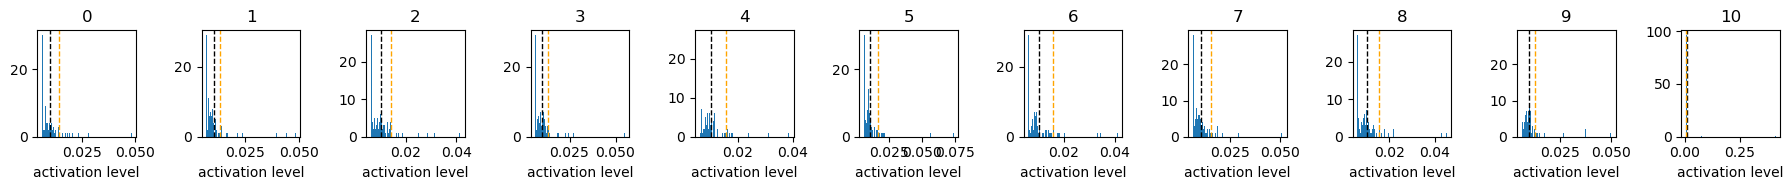

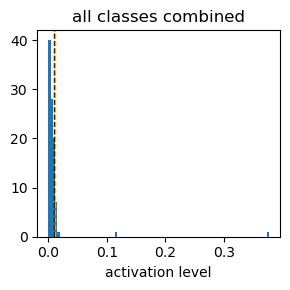

In [23]:
top_nth_threshold = 90
vis1(m1, m2, top_nth_threshold)

In [24]:
epo2 = 10

# variable parameters
hidden_size2 = 49*2 # for sae hidden dim
lr2 = 0.0001 # lr for opt2 # 0.001, etc 
sparsity_lv = 0.999 # 0.001(dense)~0.999(sparse)
# sparsity_impact = 1e-4 # 1e-4
# eps = 1e-7 # 1e-8 # epsilon

# encoder/decoder nets
enc_m = encoderNN(input_size=hidden_size, hidden_size=hidden_size2) # 49 -> 49*n
dec_m = decoderNN(hidden_size=hidden_size2, output_size=hidden_size) # 49*n -> 49

m2 = sae_model(encoder=enc_m, decoder=dec_m, sparsity_lambda=sparsity_impact, sparsity_target=sparsity_lv, epsilon=eps).to(device)
opt2 = optim.Adam(m2.parameters(), lr=lr2) # Optimizer

print("Phase2: Train sae model");
phase2(m1, m2, opt2, epo2)

Phase2: Train sae model
Epoch [1/10], loss-val: 0.0770
Epoch [2/10], loss-val: 0.0349
Epoch [3/10], loss-val: 0.0127
Epoch [4/10], loss-val: 0.0050
Epoch [5/10], loss-val: 0.0041
Epoch [6/10], loss-val: 0.0044
Epoch [7/10], loss-val: 0.0052
Epoch [8/10], loss-val: 0.0057
Epoch [9/10], loss-val: 0.0059
Epoch [10/10], loss-val: 0.0061


<br>

<h4 id="Figure-2">Figure 2</h4>

<br>

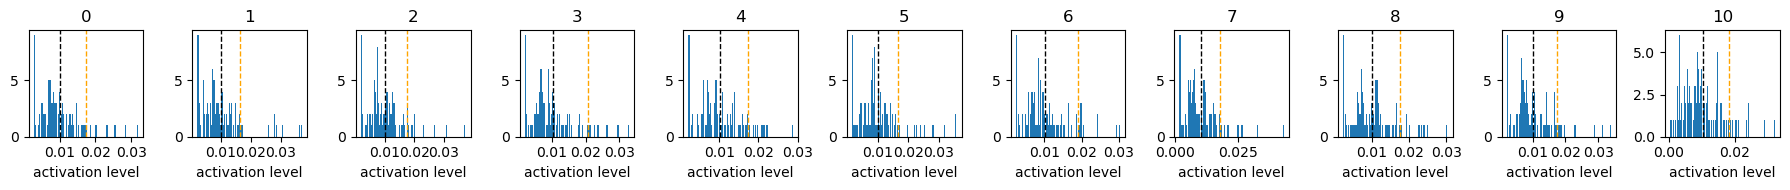

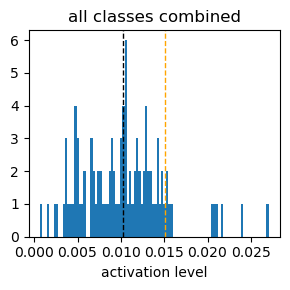

In [25]:
top_nth_threshold = 90
vis1(m1, m2, top_nth_threshold)


<br><br>

### Exp3.2. Result

- these above graphs are histograms of activation level (x-axis) of each neuron responding to each digit input.
- the "10" class is randomly scrambled digit inputs, which should be ignored, aiming to enhance to ignore background images.
- the black dotted vertical line indicates mean activation level.
- the organge dotted vertical line indicates the top 90th percentile activation level.
- when sparsity level is set to 0.1, only a few neuron is largely activated, and the rest of neurons are not activated much.
- in contrast, when sparsity level is set to 0.999, neuron activations are widely distributed.
- yet, it is unclear from these results how these distributed neuron activations contribute to representation of actual digit images.

<br>



<br>

### Exp3.3. Run second exp

Accordingly, the second exp aims to reconstruct actual digit images from the widely distributed neuron activations.

More specific questions are:

The core questions: 
- merely activating specific neurons in the hidden layer of the lin model can reconstruct human-tangible images?
- even though neuron activations are widely distributed when sparsity level is large, does a specific collection of neurons represent a specific digit image?
- are there any difficulties representing specific digit images?

The feature structures: 
- what are relationships between the original neurons in the hidden layer of the lin model? (1)
- What are relationships between the reconstructed images? (2)
- Is the (1) and the (2) correlated, or completely different relationships?

<br><br>


In [18]:
epo3 = 10
print("Phase3.1: Train img gen model"); 
phase3(m1, m3, criterion3, opt3, epo3)

Phase3.1: Train img gen model
Epoch [1/10], loss: 0.0837
Epoch [2/10], loss: 0.0765
Epoch [3/10], loss: 0.0730
Epoch [4/10], loss: 0.0710
Epoch [5/10], loss: 0.0697
Epoch [6/10], loss: 0.0689
Epoch [7/10], loss: 0.0683
Epoch [8/10], loss: 0.0678
Epoch [9/10], loss: 0.0674
Epoch [10/10], loss: 0.0670


<br>

<h4 id="Figure-3">Figure 3</h4>

<br>

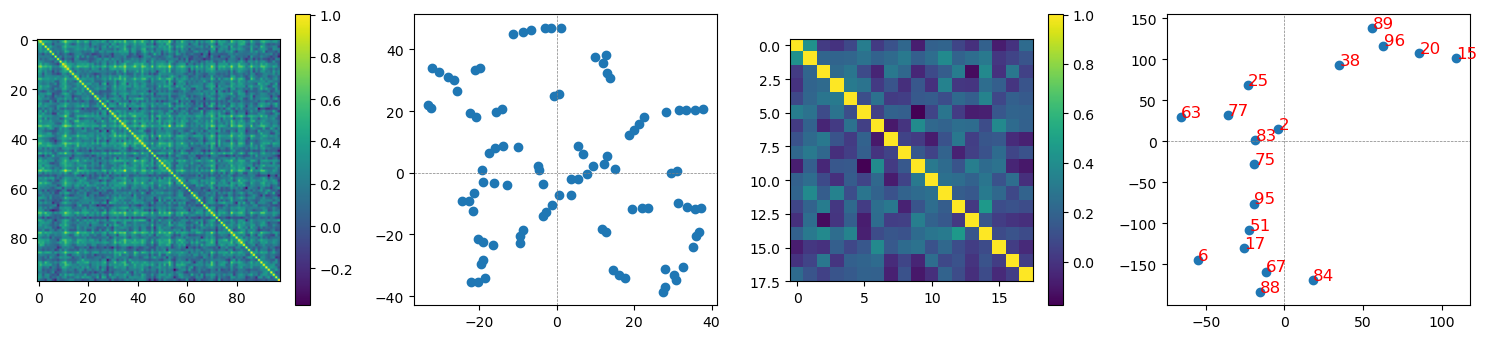

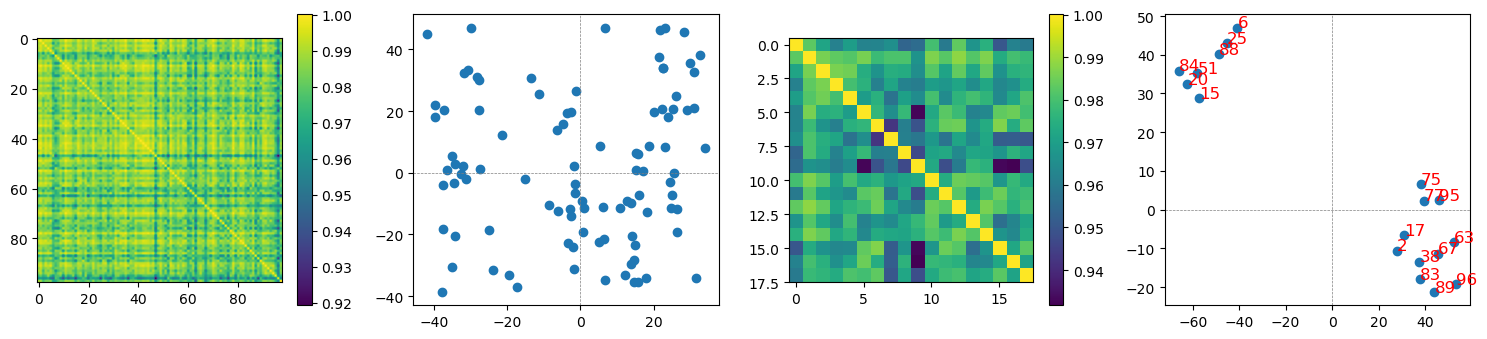

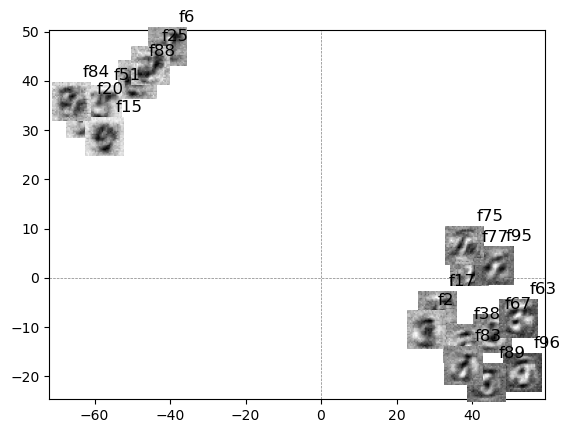

correlation btw cos sim mat, 0.6554962153023876


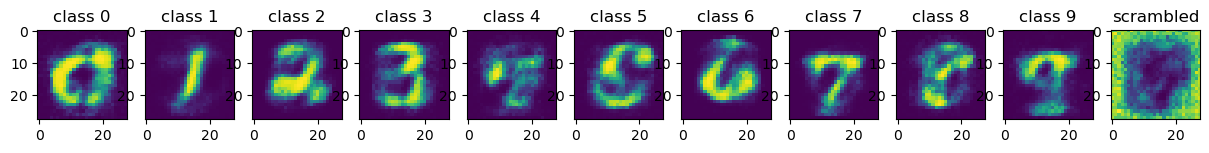

important feature indices for each class
class 0: [67 17 77  2 55 92 68 72 18 89 60 20 96 56 52 21 38 27 30 86 50 66 83 29
 73 54 97 88  3 23]
class 1: [95 75 88 76 14  6 23 20 52 61 63 15 21 60 83 90 97 46 19 84 54  8 47 80
 37 29 44 96 85 66]
class 2: [88 20 63 52 92 66 17 85 95 83 60 59  6 55 51 28 97 37 96 80 45 14  8 94
 38  4  7 77 30 21]
class 3: [67  6 95 28 33 66 38 88 54 24 92 56 17 60 72 80 96 41 20 37  7  2 23 25
 64 63 62 75 27 30]
class 4: [96 38 51 84 74 87 67  0 32 63 66 54 30 60 47 76 18  2 37 75 77  6 29 55
  8 40 93 83 28 61]
class 5: [67  2 89 95 55 54 38 21 14 28 29 18  0 72 92  8 52 77 56 83 59 66 80 88
 87 90  9 40 73 23]
class 6: [83 88 89 51  0 60 55 18 66  8 63 38 14 67 21  2 57  4 45 28 52 96 74 17
 61 47 23 94  3 77]
class 7: [ 6 75 96 20 84 38 95 63 55 72 67 30 90 97 18 51 52 47 50 56 66  8 87 37
  5 85 77 76 61 83]
class 8: [95 77 38 89 80 66 67 51 52 61 54 14  0 60 29 20  2 88 84 28 63 17 75 72
  6 83 76 87 85 40]
class 9: [96 38 95 67  6 51 77  8 97 87 8

In [19]:
vis2(m1, m2, m3)


<br><br>

### Exp3.4. Result

- the first row demonstrates cosine similarity matrices of reconstructed hidden layer neurons (the 1st and the 3rd columns) and feature structures in 2D (reducing dim by tsne data transformation).
- the second row demonstrates cosine similarity matrices of reconstructed images from the reconstructed hidden layer neurons.
- the 3rd and the 4th columns are represenations of the top 2 important features for each digit 0-9 + scrambled image.
- the 3rd row, I added the reconstructed images from selective features with feature number next to images.
- the final figure is each of reconstructed digit images from the reconstructed hidden layer neurons.
    - interestingly, some digits are reconstructed well (e.g. 0, 1, 2, 3, 7, 9), while others are struggling to reconstruct (e.g. 4, 8).
    - interestingly, struggling digits are similar to the other digits (e.g. 8 vs 9), which might be a hint to reconstruct the nuance of the digit images.
- interestingly, structures across reconstructed hidden layer neurons and structures across reconstructed images are highly correlated (0.6554962153023876).
    - does it mean that data distributions are similar based on physical features and mentally represented features?
        - in fact, digit images are extracted products from human internal representations or abstracted concepts, so it would be interesting to see if naturally existied objects will show similar patterns.

<br><br>
